In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9MB 14.7MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [ ]:
!pip install segmentation-models==1.0.1

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras import models, layers, optimizers, callbacks
import os
import keras
import pandas as pd
import ast
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
IMG_SIZE = 256
IMG_CHANNELS = 3
NUM_CLASSES = 1
BATCH_SIZE = 1
Path_Images = "/content/drive/MyDrive/Authentic Segmentation/Train/Images/"
Path_Csv = "/content/drive/MyDrive/Authentic Segmentation/Ring_poly.csv"
Path_Create_Data = "/content/drive/MyDrive/Authentic Segmentation/Train/"
Path_Train_Images = "/content/drive/MyDrive/Authentic Segmentation/Train/train_images/"
Path_Mask = "/content/drive/MyDrive/Authentic Segmentation/Train/mask/"
Path_Test_Images = "/content/drive/MyDrive/Authentic Segmentation/Test/Images"

cols_list = ['filename', 'region_shape_attributes', 'region_attributes']

In [ ]:
class Segmentation():
    def visualize_csv(self, cols_list):
        full_data = pd.read_csv(Path_Csv)
        req_data = pd.read_csv(Path_Csv, usecols=cols_list)
        return full_data, req_data
    
    def create_mask(self, csv_data):
        if os.path.isdir(Path_Create_Data+"train_images")==False:
            os.mkdir(Path_Train_Images)
            os.mkdir(Path_Mask)
            
        for i, key in enumerate(csv_data.itertuples()):
            
            img  = cv.imread(Path_Images+key.filename)
            height, width = img.shape[:2]
            mask = np.zeros((height, width), dtype=np.uint8)
            
            poly = ast.literal_eval(key.region_shape_attributes)
            x_points = poly.get('all_points_x')
            y_points = poly.get('all_points_y')
            points = []

            if x_points == None:
                points.append([])
            else:
                for i in range(len(x_points)):
                    points.append([x_points[i], y_points[i]])
                contours = np.array(points)
                cv.fillPoly(mask, [contours], color = (255))
            
            # plt.imshow(img)
            # plt.show()
            # plt.imshow(mask, cmap='binary_r')
            # plt.show()
            cv.imwrite(Path_Train_Images+key.filename, img)
            if key.filename[9]==".":
                if os.path.isdir(Path_Mask+key.filename[:9])==False:
                    os.mkdir(Path_Mask+key.filename[:9])
                cv.imwrite(Path_Mask+key.filename[:9] + "/" + str(i)+".bmp", mask)
            else:
                if os.path.isdir(Path_Mask+key.filename[:10])==False:
                    os.mkdir(Path_Mask+key.filename[:10])
                cv.imwrite(Path_Mask+key.filename[:10] + "/" + str(i)+".bmp", mask)
    
    def gen_train_data(self):
        dir_train = sorted(os.listdir(Path_Train_Images))
        dir_mask = sorted(os.listdir(Path_Mask))
        # print(len(dir_train))
        X_train = np.zeros((len(dir_train), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.uint8)
        Y_train = np.zeros((len(dir_train), IMG_SIZE, IMG_SIZE,1), dtype=np.bool)

        for i, name in enumerate(dir_train):
            # print(name)
            img = cv.imread(Path_Train_Images+"/"+name)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
            # plt.imshow(img)
            # plt.show()
            img  = np.expand_dims(img, -1)
            X_train[i] = img

        for n, direc in enumerate(dir_mask):
            # print(direc)
            new_img = np.zeros((1200,1600,1), np.bool)
            for img_name in os.listdir(os.path.join(Path_Mask,direc)):
                img = cv.imread(os.path.join(Path_Mask, direc, img_name))
                img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                _, thresh = cv.threshold(img, 128, 255, 0)
                thresh = np.expand_dims(thresh, -1)
                # print(thresh.shape)
                new_img = np.maximum(new_img, thresh)
            
            new_img = cv.resize(new_img, (IMG_SIZE,IMG_SIZE))
            new_img = np.expand_dims(new_img, -1)
            Y_train[n] = new_img
            # plt.imshow(new_img)
            # plt.show()
        # X_train = np.stack((X_train,)*3, axis=-1)
        # print(X_train.shape)
        # print(Y_train.shape)
        # print(np.unique(Y_train))
        return X_train, Y_train
    
    def gen_test_data(self):
        dir_test = os.listdir(Path_Test_Images)
        X_test = np.zeros((len(dir_test), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.uint8)
        for i, name in enumerate(dir_test):
            # print(name)
            img = cv.imread(Path_Test_Images+"/"+name)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
            # plt.imshow(img)
            # plt.show()
            img  = np.expand_dims(img, -1)
            X_test[i] = img
        return X_test

seg = Segmentation()
full_data, req_data = seg.visualize_csv(cols_list)

seg.create_mask(req_data)
X_train, Y_train = seg.gen_train_data()
X_test = seg.gen_test_data()
# plt.imshow(np.squeeze(X_test[2]), cmap='gray')
# for i in range(X_train.shape[0]):
#     plt.imshow(np.squeeze(X_train[i]), cmap='gray')
#     plt.show()
#     plt.imshow(np.squeeze(Y_train[i]), cmap='binary_r')
#     plt.show()

In [ ]:
backbone = 'efficientnetb1'
preprocess = sm.get_preprocessing(backbone)

X_train = preprocess(X_train)
print(X_train.shape)

(8, 256, 256, 3)


In [ ]:
backbone = 'densenet201'
preprocess = sm.get_preprocessing(backbone)

X_train = preprocess(X_train)
print(X_train.shape)

(8, 256, 256, 3)


In [ ]:
from sklearn.model_selection import train_test_split
X_t, X_v, Y_t, Y_v = train_test_split(X_train, Y_train, test_size=0.25, random_state = 42)
print(X_t.shape)
print(X_v.shape)
print(Y_t.shape)
print(Y_v.shape)

(6, 256, 256, 3)
(2, 256, 256, 3)
(6, 256, 256, 1)
(2, 256, 256, 1)


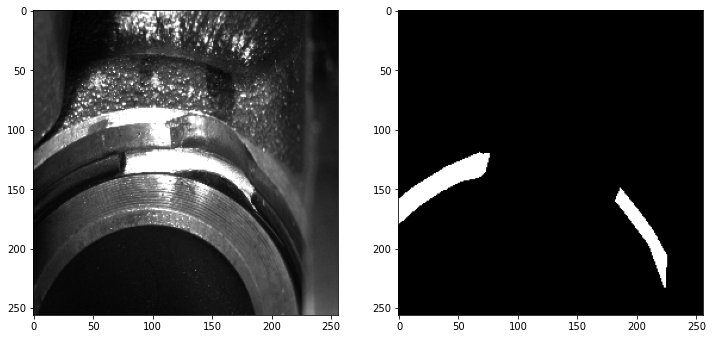

In [ ]:
import random 

img_no = random.randint(0, len(X_t)-1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_t[img_no,:,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.squeeze(Y_t[img_no]), cmap='binary_r')
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

seed = 24
aug_data_gen = ImageDataGenerator(rotation_range=75,
                                width_shift_range=0.3,
                                height_shift_range=0.3,
                                shear_range=0.5,
                                zoom_range=0.3,
                                horizontal_flip=True,
                                vertical_flip=True,
                                zca_whitening=False,
                                fill_mode='reflect')
# aug_data_gen.fit(X_t, augment=True, seed = seed)

train_gen = aug_data_gen.flow(X_t, seed=seed)
mask_train_gen = aug_data_gen.flow(Y_t, seed=seed)
valid_gen = aug_data_gen.flow(X_v, seed=seed)
mask_valid_gen = aug_data_gen.flow(Y_v, seed=seed)

def input_generator(image_gen, mask_gen):
    gene = zip(image_gen, mask_gen)
    for (img,mas) in gene:
        yield (img,mas)
training_generator = input_generator(train_gen,mask_train_gen)
validation_generator = input_generator(valid_gen, mask_valid_gen)

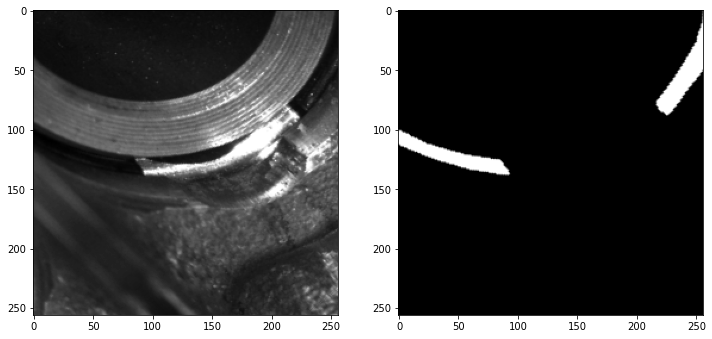

In [ ]:
x = train_gen.next()
y = mask_train_gen.next()

for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(122)
    plt.imshow(np.squeeze(mask), cmap='binary_r')
    plt.show()


In [ ]:
#model

model = sm.Unet(backbone, encoder_weights='imagenet')
model.compile("Adam",loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.IOUScore(threshold=0.5)])
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


74842112/74836368 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None

In [ ]:
# input = layers.Input((IMG_SIZE, IMG_SIZE, 1))
# norm = layers.Lambda(lambda x: x/255)(input)

# #Layer 1
# conv1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(norm)
# drop1 = layers.Dropout(0.1)(conv1)
# conv1 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(drop1)
# pool1 = layers.MaxPooling2D((2,2))(conv1)

# #Layer 2
# conv2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
# drop2 = layers.Dropout(0.1)(conv2)
# conv2 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(drop2)
# pool2 = layers.MaxPooling2D((2,2))(conv2)

# #Layer 3
# conv3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
# drop3 = layers.Dropout(0.1)(conv3)
# conv3 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(drop3)
# pool3 = layers.MaxPooling2D((2,2))(conv3)

# #Layer 4
# conv4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
# drop4 = layers.Dropout(0.1)(conv4)
# conv4 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(drop4)
# pool4 = layers.MaxPooling2D((2,2))(conv4)

# #Layer 5
# conv5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
# drop5 = layers.Dropout(0.1)(conv5)
# conv5 = layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(drop5)

# #Decoder

# #Layer 6
# conv6 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv5)
# concat6 = layers.concatenate([conv6, conv4])
# conv6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(concat6)
# drop6 = layers.Dropout(0.1)(conv6)
# conv6 = layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(drop6)


# #Layer 7
# conv7 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv6)
# concat7 = layers.concatenate([conv7, conv3])
# conv7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(concat7)
# drop7 = layers.Dropout(0.1)(conv7)
# conv7 = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(drop7)

# #Layer 8
# conv8 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv7)
# concat8 = layers.concatenate([conv8, conv2])
# conv8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(concat8)
# drop8 = layers.Dropout(0.1)(conv8)
# conv8 = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(drop8)

# #Layer 9
# conv9 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(conv8)
# concat9 = layers.concatenate([conv9, conv1])
# conv9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(concat9)
# drop9 = layers.Dropout(0.1)(conv9)
# conv9 = layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(drop9)

# output = layers.Conv2D(1, (1,1), activation='sigmoid')(conv9)

# model = tf.keras.Model(inputs=[input], outputs=[output])
# model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
callback = [keras.callbacks.ModelCheckpoint(Path_Create_Data+"/"+"model.{epoch:02d}-{iou_score:.2f}.h5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=10)]
result = model.fit(training_generator, validation_data=validation_generator, steps_per_epoch=40, epochs=70, validation_steps=40, callbacks=callback)
model.save(Path_Create_Data+"/"+"densenet.h5")

Epoch 1/70
40/40 [==============================] - 707s 18s/step - loss: 0.8618 - iou_score: 0.1895 - val_loss: 1.4698 - val_iou_score: 0.0103
Epoch 2/70
40/40 [==============================] - 688s 17s/step - loss: 0.4804 - iou_score: 0.4868 - val_loss: 1.1648 - val_iou_score: 8.7091e-06
Epoch 3/70
40/40 [==============================] - 686s 17s/step - loss: 0.3108 - iou_score: 0.5949 - val_loss: 0.9811 - val_iou_score: 0.0305
Epoch 4/70
40/40 [==============================] - 708s 18s/step - loss: 0.2532 - iou_score: 0.6494 - val_loss: 1.2585 - val_iou_score: 0.0086
Epoch 5/70
40/40 [==============================] - 746s 19s/step - loss: 0.2027 - iou_score: 0.7101 - val_loss: 1.1115 - val_iou_score: 0.0054
Epoch 6/70
40/40 [==============================] - 722s 18s/step - loss: 0.1973 - iou_score: 0.7166 - val_loss: 0.8760 - val_iou_score: 0.1076
Epoch 7/70
40/40 [==============================] - 712s 18s/step - loss: 0.1849 - iou_score: 0.7296 - val_loss: 1.0524 - val_iou_sc

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model(Path_Create_Data+"/"+"model.40-0.27.h5", compile=False)
model.compile("Adam",loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
# print(model.summary())
# result = model.fit(training_generator, validation_data=validation_generator, steps_per_epoch=40, epochs=10, validation_steps=40)
# model.save(Path_Create_Data+"/"+"more10epoch.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# checkpoint = callbacks.ModelCheckpoint('Ring_Segment', verbose=1, save_best_only=True)
# callbacks = [callbacks.EarlyStopping(patience=3, monitor='val_loss'),callbacks.TensorBoard(log_dir='logs')]
result = model.fit(training_generator, validation_data=validation_generator, steps_per_epoch=50, epochs=85, validation_steps=50)
model.save(Path_Create_Data+"/"+"effi.h5")

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/85
50/50 [==============================] - 545s 11s/step - loss: 1.3500 - iou_score: 0.0523 - val_loss: 1.3195 - val_iou_score: 0.0271
Epoch 2/85
50/50 [==============================] - 528s 11s/step - loss: 0.8015 - iou_score: 0.3064 - val_loss: 2.1700 - val_iou_score: 0.0369
Epoch 3/85
50/50 [==============================] - 527s 11s/step - loss: 0.4330 - iou_score: 0.6169 - val_loss: 2.8739 - val_iou_score: 0.0361
Epoch 4/85
50/50 [==============================] - 530s 11s/step - loss: 0.2910 - iou_score: 0.7430 - val_loss: 6.7031 - val_iou_score: 0.0355
Epoch 5/85
50/50 [==============================] - 529s 11s/step - loss: 0.2425 - iou_score: 0.7871 - val_loss: 1.1317 - val_iou_score: 0.0055
Epoch 6/85
50/50 [==============================] - 528s 11s/step - loss: 0.2090 - iou_score: 0.8155 - val_loss: 1.3754 - val_iou_score: 7.3344e-04
Epoch 7/85
50/50 [==============================] - 529s 11s/step - loss: 0.1929 - iou_score: 0.8307 - val_loss: 1.8296 - val_iou_sc

6/6 [==============================] - 5s 756ms/step


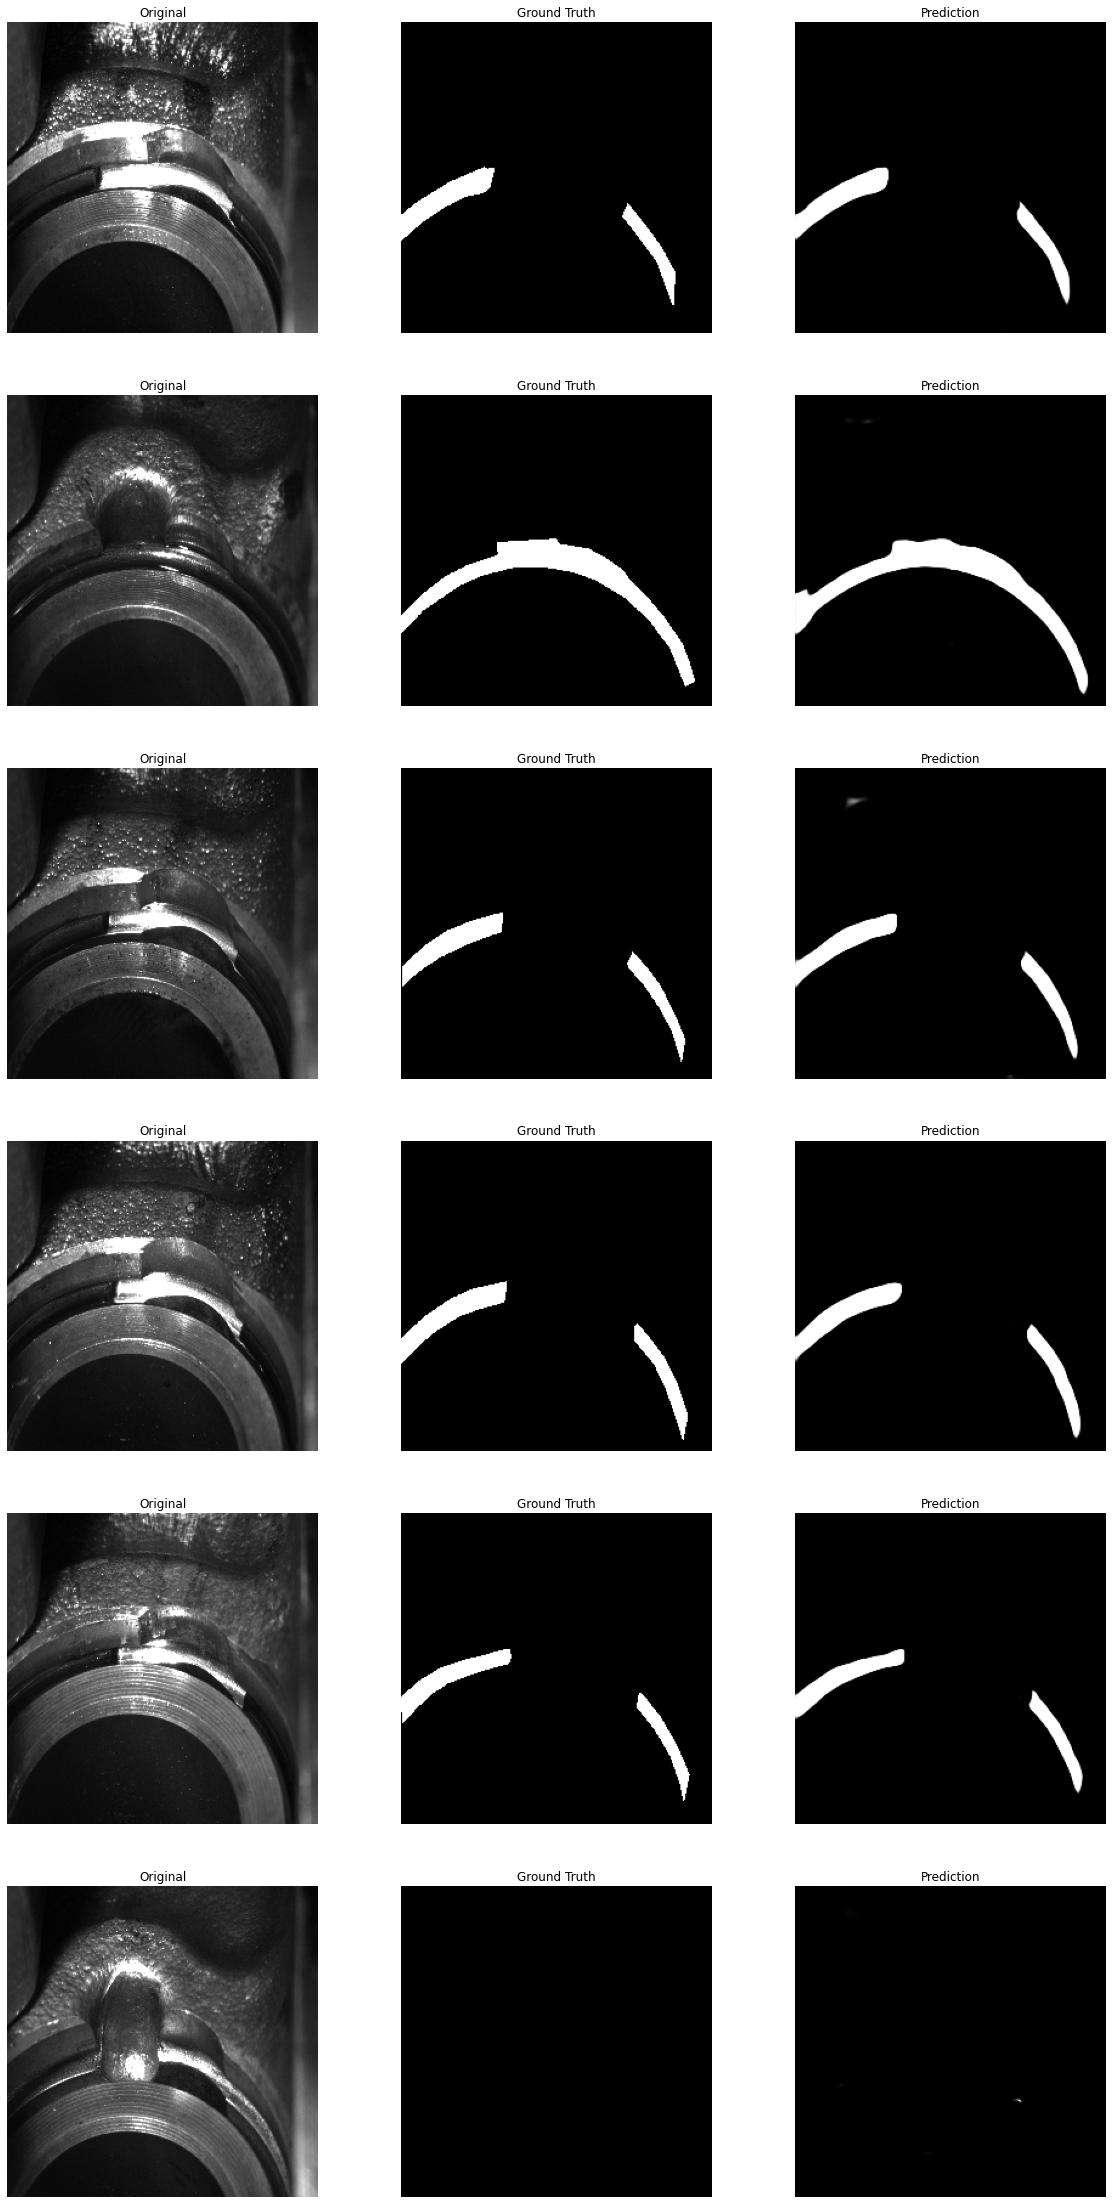

In [ ]:
#Prediction
# pred_train = model.predict(X_train[:int(X_train.shape[0]*0.75)],verbose = 1)
# pred_valid = model.predict(X_train[int(X_train.shape[0]*0.75):], verbose = 1)
pred_test = model.predict(X_t, verbose=1)

# train_predict = (pred_train>0.1).astype(np.uint8)
# valid_predict = (pred_valid>0.1).astype(np.uint8)
# test_predict = (pred_test>0.9).astype(np.uint8)


# print(np.unique(pred_test[0]))

# create figure

# setting values to rows and column variables
rows = 1
columns = 3
fig, axes = plt.subplots(len(X_t), 3,figsize=(20,40))
for i in range(len(X_train)-2):
  
# showing image
    axes[i, 0].imshow(np.squeeze(X_t[i,:,:, 0]), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Original")
  
# # showing image
    axes[i, 1].imshow(np.squeeze(Y_t[i]), cmap='binary_r')
    axes[i, 1].axis('off')
    axes[i, 1].set_title("Ground Truth")
  
# Adds a subplot at the 3rd position

# showing image
    axes[i, 2].imshow(np.squeeze(pred_test[i]), cmap='binary_r')
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Prediction")
  
